In [ ]:
import numpy as np

# 딥러닝 학습 기술

- Optimization (매개변수 갱신(확률적 경사하강법, 모멘텀, AdaGrad, Adam) )

- Weight Decay
- Batch Normalization
- 과대적합(Overfitting) / 과소적합(Underfitting)
- 규제화(Regularization)
- 드롭아웃(Drop Out)
- 하이퍼 파라미터
  - 학습률(Learning Rate)
  - 학습횟수
  - 미니배치 크기



## 최적화 방법 : 매개변수 갱신

### 확률적 경사하강법(Stochastic Gradient Descent, SGD)

  - 전체를 한번에 계산하지 않고, **확률적**으로 일부 샘플을 뽑아 조금씩 나누어 학습을 시키는 과정  
  
  - 반복할 때마다 다루는 데이터의 수가 적기때문에 한 번 처리하는 속도는 빠름  

  - 한 번 학습할 때 필요한 메모리만 있으면 되므로 매우 큰 데이터셋에 대해서도 학습이 가능

  - 확률적이기 때문에, 배치 경사하강법보다 불안정

  - 손실함수의 최솟값에 이를 때까지 다소 위아래로 요동치면서 이동

  - 따라서, 위와 같은 문제 때문에 **미니 배치 경사하강법**(mini-batch gradient descent)로 학습을 진행  
    요즘에는 보통 SGD라고하면 미니 배치 경사하강법을 의미하기도 함

  
  - (참고)
    - <code>배치 경사하강법</code>
    - <code>미니 배치 경사하강법</code>
    - <code>확률적 경사하강법</code>
  
  <br>

  ## $\quad W \leftarrow W - \gamma \frac{\partial L}{\partial W}$  
   - $\gamma :\ $ 학습률

  <br>

![](https://engmrk.com/wp-content/uploads/2018/04/Fig2.png)
<sub>출처: https://engmrk.com/mini-batch-gd/</sub>


  





In [ ]:
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [ ]:
optimizer = SGD()

# for i in range(10000):
  # optimizer.update(params, grads)

### SGD의 단점
- 단순하지만, 문제에 따라서 시간이 매우 오래걸림

### 모멘텀(Momentum)
- 운동량을 의미, 관성과 관련

- 공이 그릇의 경사면을 따라서 내려가는 듯한 모습

- 이전의 속도를 유지하려는 성향  
  경사하강을 좀 더 유지하려는 성격을 지님

- 단순히 SGD만 사용하는 것보다 적게 방향이 변함
  
![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-4470-8_33/MediaObjects/463852_1_En_33_Fig1_HTML.jpg)

<sub>출처: https://link.springer.com/chapter/10.1007/978-1-4842-4470-8_33</sub>

$
\qquad v \ \leftarrow \ \alpha \ v - \gamma \ \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \ v
$

  - $\alpha\ $ : 관성계수

  - $v$ :  속도

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : 손실함수에 대한 미분


In [ ]:
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
      params[key] += self.v[key]

### AdaGrad(Adaptive Gradient)
- **가장 가파른 경사를 따라 빠르게 하강하는 방법**

- 적응적 학습률이라고도 함
  학습률을 **변화시키며 진행**

- 경사가 급할 때는 빠르게 변화,  
  완만할 때는 느리게 변화

- 간단한 문제에서는 좋을 수는 있지만 딥러닝(Deep Learning)에서는 자주 쓰이지 않음
  학습률이 너무 감소되어 전역최소값(global minimum)에 도달하기 전에   
  학습이 빨리 종료될 수 있기 때문


<br>

$
\qquad h \ \leftarrow \  h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \gamma \frac{1}{\sqrt h} \ \frac{\partial L}{\partial W}
$

  <br>

  - $h\ $ : 기존 기울기를 제곱하여 더한 값

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

  <br>

  - (참고)  
    - 과거의 기울기를 제곱하여 계속 더해하기 때문에  
      학습을 진행할수록 갱신 강도가 약해짐($\because \frac{1}{\sqrt h}$)    
  

In [ ]:
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0이 되지 않도록 작은 값 더해줌

### RMSProp (Root Mean Square Propagation)
- AdaGrad를 보완하기 위한 방법으로 등장

- 합 대신 지수의 평균값을 활용

- 학습이 안되기 시작하면 학습률이 커져 잘 되게끔하고,  
  학습률이 너무 크면 학습률을 다시 줄임


<br>

$
\qquad h \ \leftarrow \  \rho \ h + (1 - \rho)\ \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \gamma \frac{\partial L}{\partial W} / \ \sqrt{h + \epsilon}
$

  <br>

  - $h\ $ : 기존 기울기를 제곱하여 업데이트 계수를 곱한 값과 업데이트 계수를 곱한 값을 더해줌

  - $\rho\ $ : 지수 평균의 업데이트 계수

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

In [ ]:
class RMSProp:
  def __init__(self, lr=0.01, decay_rate=0.9):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] *= self.decay_rate
      self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
      params[key] -= self.lr * grads[key]

### Adam (Adaptive moment estimation)
- 모멘텀 최적화와 RMSProp의 아이디어를 합친 것

- 지난 그래디언트의 지수 감소 평균을 따르고(Momentum), 지난 그레디언트 제곱의 지수 감소된 평균(RMSProp)을 따름

- 가장 많이 사용되는 최적화 방법


<br>

$
\qquad t \ \leftarrow \ t + 1 \\
\qquad m_t \ \leftarrow \  \beta_1 \ m_{t-1} - (1 - \beta_1)\ \frac{\partial L}{\partial W}  \\
\qquad v_t \ \leftarrow \ \beta_2 \ v_{t-1} + (1 - \beta_2) \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad \hat{m_t} \ \leftarrow \frac{m_t}{1 - \beta_1^t} \\
\qquad \hat{v_t} \ \leftarrow \frac{v_t}{1 - \beta_2^t} \\
\qquad W_t \ \leftarrow \ W_{t-1} \ + \gamma \ \hat{m_t}\  / \sqrt{\hat{v_t} + \epsilon}
$

  <br>

  - $\beta\ $ : 지수 평균의 업데이트 계수

  - $\gamma\ $ : 학습률

  - $\beta_1 \approx 0.9\ ,\ \ \beta_2 \approx 0.999$

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

In [ ]:
class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

    for key in params.keys():
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## 최적화 방법 비교 (예, Linear Regression)

<img src="https://user-images.githubusercontent.com/11681225/50016682-39742a80-000d-11e9-81da-ab0406610b9c.gif" width="600">

<sub>출처: https://github.com/ilguyi/optimizers.numpy</sub>

## AI 두 번째 위기 (가중치 소실, Gradient Vanishing)

- 활성화함수가 Sigmoid 함수 일 때, 은닉층의 갯수가 늘어 날수록  
  가중치가 역전파되면서 가중치 소실문제 발생
  - 0 ~ 1 사이의 값으로 출력되면서 0 또는 1에 가중치 값이 퍼짐  
    이는 <u>미분값이 점점 0에 가까워짐</u>을 의미하기도 한다.

  - **ReLU 함수 등장(비선형 함수)**

- 가중치 초기화 문제(은닉층의 활성화값 분포)
  - 가중치의 값이 일부 값으로 치우치게 되면  
    활성화 함수를 통과한 값이 치우치게 되고, 표현할 수 있는 신경망의 수가 적어짐.

  - 따라서, 활성화값이 골고루 분포되는 것이 중요!

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F278186%2Fd158ec3585bc1551d9f3a03ae13a3a73%2Fvanishing%20gradient%20problem.png?generation=1574233763365617&alt=media)

<sub>출처: https://www.kaggle.com/getting-started/118228</sub>

## 가중치 초기화

* https://www.deeplearning.ai/ai-notes/initialization/

### 초기값 : 0 (zeros)

- 학습이 올바르게 진행되지 않음

- 0으로 설정하면  
  오차역전파법에서 모든 가중치의 값이 똑같이 갱신됨

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.zeros((nodes, nodes))
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : 균일분포(Uniform)
- 활성화 값이 균일하지 않음(활성화함수 : sigmoid)

- 역전파로 전해지는 기울기값이 사라짐

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.uniform(1, 10, (nodes, nodes))
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : 정규분포(nomalization)
- 활성화함수를 통과하면 양쪽으로 퍼짐

- 0과 1에 퍼지면서 기울기 소실문제(gradient vanishing) 발생

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes)
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 아주 작은 정규분포값으로 가중치 초기화
- 0과 1로 퍼치지는 않았고, 한 곳에 치우쳐 짐

- 해당 신경망이 표현할 수 있는 문제가 제한됨

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * 0.01
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot)
- 은닉층의 노드의 수가 n이라면 표준편차가 $\frac{1}{\sqrt{n}}$인 분포

- 더 많은 가중치에 역전파가 전달 가능하고,  
  비교적 많은 문제를 표현할 수 있음

- 활성화 함수가 **선형**인 함수일 때 매우 적합

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot) - tanh
- 활성화 함수: tanh

- sigmoid 함수보다 더 깔끔한 종모양으로 분포  


In [ ]:
def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
  a = np.dot(x, w)
  z = tanh(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## 비선형 함수에서의 가중치 초기화

### 초기값: 0 (Zeros)
- 활성화함수: ReLU

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.zeros((nodes, nodes))
  a = np.dot(x, w)
  z = ReLU(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값: 정규분포(Nomalization)
- 활성화함수 : ReLU

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes)
  a = np.dot(x, w)
  z = ReLU(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#### 표준편차: 0.01 일 때

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * 0.01
  a = np.dot(x, w)
  z = ReLU(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot)

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
  a = np.dot(x, w)
  z = ReLU(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : He
- 표준편차가 $\sqrt{\frac{2}{n}}$인 분포

- 활성화값 분포가 균일하게 분포되어 있음

- 활성화함수가 ReLU와 같은 **비선형**함수 일 때 더 적합하다고 알려진 분포

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layer_size = 6
activation_values = {}

for i in range(hidden_layer_size):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * np.sqrt(2/nodes)
  a = np.dot(x, w)
  z = ReLU(a)
  activation_values[i] = z

In [ ]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0,1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## 배치 정규화 (Batch Normalization)

- 가중치의 활성화값이 적당히 퍼지게끔 '강제'로 적용시키는 것

- 미니배치 단위로 데이터의 평균이 0, 표준편차가 1로 정규화

- 학습을 빨리 진행할 수 있음

- 초기값에 크게 의존하지 않아도 됨

- 과적합을 방지

- 보통 Fully-Connected와 활성화함수(비선형) 사이에 놓임

![](https://www.jeremyjordan.me/content/images/2018/01/Screen-Shot-2018-01-23-at-2.27.20-PM.png)

<sub>출처: https://www.jeremyjordan.me/batch-normalization/</sub>

In [ ]:
class BarchNormalization:
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.input_shape = None

    self.running_mean = running_mean
    self.running_var = running_var

    self.batch_size = None
    self.xc = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, input_data, is_train=True):
    self.input_shape = input_data.shape
    if input_data.ndim != 2:
      N, C, H, W = input_data.shape
      input_data = input_data.reshape(N, -1)

    out = self.__forward(input_data, is_train)

    return out.reshape(*self.input_shape)

  def __forward(self, input_data, is_train): # __ -> 내부적으로만 상속 가능
    if self.running_mean is None:
      N, D = input_data.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if is_train:
      mu = input_data.mean(axis=0)
      xc = input_data - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = input_data.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std

      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mu
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

    else:
      xc = input_data - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx

  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx

## 과대적합(Overfitting) / 과소적합(Underfitting)

![](https://miro.medium.com/max/2400/1*UCd6KrmBxpzUpWt3bnoKEA.png)

<sub>출처: https://towardsdatascience.com/underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6fe4a8a49dbf</sub>

### 과대적합 (Overfitting, 오버피팅)
- 모델이 학습 데이터에 한에서만 좋은 성능을 보이고 새로운 데이터에는 그렇지 못한 경우

- 학습 데이터가 매우 적을 경우

- 모델이 지나치게 복잡한 경우

- 학습 횟수가 매우 많을 경우

<br>

- 해결방안
  - 학습 데이터를 다양하게 수집

  - 모델을 단순화
    - 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄이거나
  
  - 정규화(Regularization)을 통한 규칙을 단순화

  - 적정한 하이퍼 파라미터 찾기

### 과소적합 (Underfitting, 언더피팅)
- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋을 경우

- 모델이 지나치게 단순한 경우

<br>

- 해결방안
  - 충분한 학습 데이터 수집

  - 보다 더 복잡한 모델

  - 에폭수(epochs)를 늘려 충분히 학습

## 규제화(Regularization) - 가중치 감소

- 과대적합(Overfitting, 오버피팅)을 방지하는 방법 중 하나

- 과대적합은 가중치의 매개변수 값이 커서 발생하는 경우가 많음  
  이를 방지하기 위해 **큰 가중치 값에 큰 규제를 가하는 것**

- 규제란 가중치의 절댓값을 가능한 작게 만드는 것으로,  
  가중치의 모든 원소를 0에 가깝게 하여 모든 특성이 출력에 주는 영향을 최소한으로 만드는 것(기울기를 작게 만드는 것)을 의미한다.  
  즉, 규제란 과대적합이 되지 않도록 모델을 강제로 제한한다는 의미

- 적절한 규제값을 찾는 것이 중요.


### L2 규제
- 가중치의 제곱합

- 손실 함수일정 값을 더함으로써 과적합을 방지

- $\lambda$ 값이 크면 가중치 감소가 커지고,  
  작으면 가하는 규제가 적어진다.

- 더 Robust한 모델을 생성하므로 L1보다 많이 사용됨

<br>

## $\qquad Cost = \frac{1}{n} \sum{^n}_{i=1} {L(y_i, \hat{y_i}) + \frac{\lambda}{2}w^2}$

### $\quad L(y_i, \hat{y_i})$ : 기존 Cost Function

In [ ]:
def loss(x, true_y):

  # weight_decay += 0.5 * weight_decay_lambda * np.sum(W**2)A
  # return weight_decay

### L1 규제
- 가중치의 절대값합

- L2 규제와 달리 어떤 가중치는 0이 되는데 이는 모델이 가벼워짐을 의미

<br>

## $\qquad Cost = \frac{1}{n} \sum{^n}_{i=1} {L(y_i, \hat{y_i}) + \frac{\lambda}{2}|w|}$

### $\quad L(y_i, \hat{y_i})$ : 기존 Cost Function

In [ ]:
def loss(x, true_y):

  # weight_decay += 0.5 * weight_decay_lambda * np.sum(np.abs(W))
  # return weight_decay

## 드롭아웃(Dropout)

- 과적합을 방지하기 위한 방법

- 학습할 때 사용하는 노드의 수를 전체 노드 중에서 **일부만을 사용**

- 보통 ratio_value는 0.5 또는 0.7

![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

<sub>출처: https://medium.com/konvergen/understanding-dropout-ddb60c9f98aa</sub>

In [ ]:
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, input_data, is_train=True):
    if is_train:
      self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
      return input_data * self.mask
    else:
      return input_data * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask



## 하이퍼 파라미터(Hyper Parameter)

### 학습률(Learning Rate)
- 적절한 학습률에 따라 학습정도가 달라짐  
  **적당한** 학습률을 찾는 것이 핵심

### 학습 횟수(Epochs)
- 학습 횟수를 너무 작게, 또는 너무 크게 지정하면  
  과소적합 또는 과적합을 띈다.

- 몇 번씩 진행하면서 최적의 epochs값을 찾아야한다.

### 미니배치 크기(Mini Batch Size)
- 미니 배치 학습
  - 한번 학습할 때 메모리의 부족현상을 막기 위해  
    전체 데이터의 일부를 여러번 학습하는 방식

- 한번 학습할 때마다 얼마만큼의 미니배치 크기를 사용할지 결정

- 배치 크기가 작을수록 학습 시간이 많이 소요되고,  
  클수록 학습 시간이 학습 시간은 적게 소요된다.  
  

### 검증데이터(Validation Data)
- 주어진 데이터를  
  학습 + 검증 + 테스트 데이터로 구분하여 과적합을 방지

- 일반적으로 전체 데이터의 2~30%를 테스트 데이터,  
  나머지에서 20%정도를 검증용 데이터,  
  남은 부분을 학습용 데이터로 사용

![](https://miro.medium.com/max/1400/1*4G__SV580CxFj78o9yUXuQ.png)

<sub>출처: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6</sub>

## MNIST 분류

### Modules Import

In [ ]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

### 데이터 로드

In [80]:
np.random.seed(42)

(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_classes = 10

### 데이터 전처리

In [82]:
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:10000]
x_test = x_test[:10000]
y_train = y_train[:10000]
y_test = y_test[:10000]

In [ ]:
x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32)
x_train, x_test = x_train/.255, x_test/.255

y_train = np.eye(num_classes)[y_train]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

### Hyper Parameters

In [ ]:
epochs = 1000
lr = 1e-2
batch_size = 256
train_size = x_train.shape[0]
iter_per_epoch = max(train_size/batch_size, 1)

### Util Functions

In [ ]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
  return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))



### Util Classes

#### ReLU

In [ ]:
class ReLU:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

#### Sigmoid

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

#### Layer

In [ ]:
class Layer:
  def __init__(self, W, b):
    self.W = W
    self.W

    self.x = None
    self.original_x_shape = None

    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.W)
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape)
    return dx

#### Batch Normalization

In [ ]:
class BarchNormalization:
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.input_shape = None

    self.running_mean = running_mean
    self.running_var = running_var

    self.batch_size = None
    self.xc = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, input_data, is_train=True):
    self.input_shape = input_data.shape
    if input_data.ndim != 2:
      N, C, H, W = input_data.shape
      input_data = input_data.reshape(N, -1)

    out = self.__forward(input_data, is_train)

    return out.reshape(*self.input_shape)

  def __forward(self, input_data, is_train):
    if self.running_mean is None:
      N, D = input_data.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if is_train:
      mu = input_data.mean(axis=0)
      xc = input_data - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = input_data.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std

      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mu
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

    else:
      xc = input_data - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx

  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx

#### Dropout


In [ ]:
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, input_data, is_train=True):
    if is_train:
      self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
      return input_data * self.mask
    else:
      return input_data * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask



#### Softmax

In [ ]:
class Softmax:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]

    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx

## Model

### 모델 생성 및 학습 1
- 사용한 기법
  - 학습데이터 수 10,000

  - Hidden Layers : 4
    - [100, 100, 100, 100]
  - SGD
  - EPOCHS : 1000
  - 학습률 : 1e-2 (0.01)
  - 배치사이즈 : 256
  - 드롭아웃 : 0.2
  - 배치 정규화
  - 규제화 : 0.1

In [73]:

class MyModel:
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', decay_lambda=0.1,
                 use_dropout=False, dropout_ratio=0.2, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)

        self.use_dropout = use_dropout
        self.decay_lambda = decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        self.__init_weight(activation)

        activation_layer = {'sigmoid': Sigmoid, 'relu': ReLU}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])

            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx - 1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BarchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
        self.last_layer = Softmax()

    def __init_weight(self, activation):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

        for idx in range(1, len(all_size_list)):
            scale = None
            if activation.lower() == 'relu':
                scale = np.sqrt(2.0 / all_size_list[idx-1])
            elif activation.lower() == 'sigmoid':
                scale = np.sqrt(1.0 / all_size_list[idx-1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, is_train=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key: # train일 때만 Dropout, BatchNorm 가능 
                x = layer.forward(x, is_train)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, is_train=False):
        y = self.predict(x, is_train)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t, is_train=True)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() # 역전파를 하기 위해서 reverse
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dW + self.decay_lambda * self.layers['Layer' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Layer' + str(idx)].db

            if self.use_batchnorm and idx <= self.hidden_layer_num:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


In [ ]:
decay_lambda = 0.1
model_1 = MyModel(input_size=784, hidden_size_list=[256, 100, 64, 32], output_size=10, activation='relu',
                  decay_lambda=decay_lambda, use_batchnorm=True)


In [ ]:
optimizer = SGD(lr=lr)

In [ ]:
model_1_train_loss_list = []
model_1_train_acc_list = []
model_1_test_acc_list = []

In [ ]:
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]

    grad = model_1.gradient(x_batch, y_batch)
    optimizer.update(model_1.params, grad)

    loss = model_1.loss(x_batch, y_batch)
    model_1_train_loss_list.append(loss)

    if epoch % 50 == 0:
        train_acc = model_1.accuracy(x_train, y_train)
        test_acc = model_1.accuracy(x_test, y_test)
        model_1_train_acc_list.append(train_acc)
        model_1_test_acc_list.append(test_acc)
        print('[Model 1] Epoch: {}  Train Loss: {:.4f} Train Accuracy: {:.4f} Test Accuracy: {:.4f}'.format(epoch, loss, train_acc, test_acc))


#### 시각화

In [ ]:
x = np.arange(len(model_1_train_acc_list))

plt.plot(x, model_1_train_acc_list, 'b', label='train', markersize=3)
plt.plot(x, model_1_train_acc_list, 'r--', label='test', markersize=3)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()

In [ ]:
x = np.arange(len(model_1_train_loss_list))

plt.plot(x, model_1_train_loss_list, 'g--', label='train', markersize=3)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### 모델 생성 및 학습 2
- 사용한 기법
  - 학습데이터 수 10,000

  - Hidden Layers = 4
    - [100, 100, 100, 100]
  - Adam
  - EPOCHS : 1000
  - 학습률 : 1e-3 (0.001)
  - 배치사이즈 : 100
  - 드롭아웃 : 0.5
  - 배치 정규화
  - 규제화 : 0.15

In [77]:
def make_graph(model, model_train_loss_list, model_train_acc_list, model_test_acc_list):
	# train acc graph
	x = np.arange(len(model_train_acc_list))

	plt.plot(x, model_train_acc_list, 'b', label='train', markersize=3)
	plt.plot(x, model_test_acc_list, 'r--', label='test', markersize=3)
	plt.xlabel('epochs')
	plt.ylabel('Accuracy')
	plt.grid()
	plt.ylim(0, 1.0)
	plt.legend()
	plt.show()

	# train loss graph
	x = np.arange(len(model_train_loss_list))

	plt.plot(x, model_train_loss_list, 'g--', label='train', markersize=3)
	plt.xlabel('epochs')
	plt.ylabel('Loss')
	plt.grid()
	plt.legend()
	plt.show()
		

def train_epoch(model, test_case, lr, epochs, train_size, batch_size, optimizer, iter_per_epoch):

	# optimizer(lr=lr)

	model_train_loss_list = []
	model_train_acc_list = []
	model_test_acc_list = []
	
	for epoch in range(epochs):
		batch_mask = np.random.choice(train_size, batch_size)
		x_batch = X_train[batch_mask]
		y_batch = y_train[batch_mask]

		grad = model.gradient(x_batch, y_batch)
		optimizer.update(model.params, grad)

		loss = model.loss(x_batch, y_batch)
		model_train_loss_list.append(loss)

		if epoch % 50 == 0:
			train_acc = model.accuracy(x_train, y_train)
			test_acc = model.accuracy(x_test, y_test)
			model_train_acc_list.append(train_acc)
			model_test_acc_list.append(test_acc)
			print(f'[Model_{test_case}] Epoch: {epoch}  Train Loss: {round(loss, 4)} Train Accuracy: {round(train_acc, 4)} Test Accuracy: {round(test_acc, 4)}')
	
	make_graph(model, model_train_loss_list, model_train_acc_list, model_test_acc_list)




[Model_2] Epoch: 0  Train Loss: 293.2466 Train Accuracy: 0.0868 Test Accuracy: 0.0859
[Model_2] Epoch: 50  Train Loss: 245.2543 Train Accuracy: 0.3765 Test Accuracy: 0.3784
[Model_2] Epoch: 100  Train Loss: 218.8218 Train Accuracy: 0.5703 Test Accuracy: 0.5521
[Model_2] Epoch: 150  Train Loss: 181.9135 Train Accuracy: 0.6644 Test Accuracy: 0.6436
[Model_2] Epoch: 200  Train Loss: 156.5379 Train Accuracy: 0.7035 Test Accuracy: 0.6942
[Model_2] Epoch: 250  Train Loss: 129.3761 Train Accuracy: 0.7109 Test Accuracy: 0.7005
[Model_2] Epoch: 300  Train Loss: 103.6722 Train Accuracy: 0.7089 Test Accuracy: 0.6949
[Model_2] Epoch: 350  Train Loss: 87.708 Train Accuracy: 0.753 Test Accuracy: 0.7387
[Model_2] Epoch: 400  Train Loss: 87.6354 Train Accuracy: 0.7695 Test Accuracy: 0.7583
[Model_2] Epoch: 450  Train Loss: 78.9067 Train Accuracy: 0.8206 Test Accuracy: 0.8023
[Model_2] Epoch: 500  Train Loss: 79.289 Train Accuracy: 0.7785 Test Accuracy: 0.7544
[Model_2] Epoch: 550  Train Loss: 68.1544 

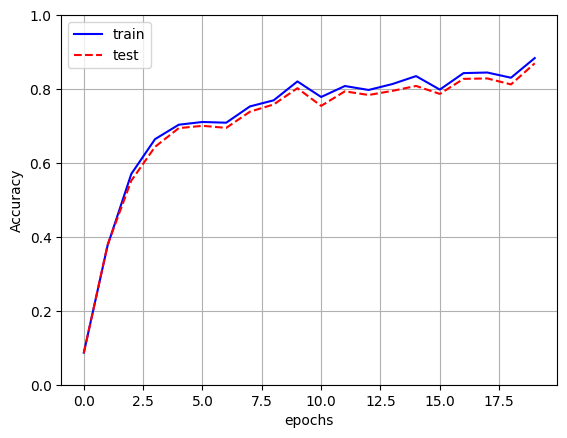

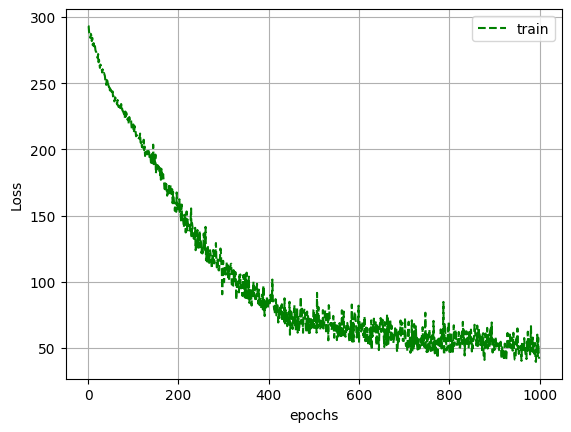

In [78]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [100, 100, 100, 100],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.15,
				'use_dropout' : True,
				'dropout_ratio' : 0.5, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 2,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 100,
				'epochs' : 1000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

### 모델 생성 및 학습 3

- 사용한 기법
  - 학습데이터 수 20,000

  - Hidden Layers = 3
    - [256, 100, 100]
  - Adam
  - EPOCHS : 1000
  - 학습률 : 1e-2 (0.01)
  - 배치사이즈 : 100
  - 배치정규화



In [96]:
np.random.seed(42)

train_size = 20000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:train_size]
x_test = x_test[:10000]
y_train = y_train[:train_size]
y_test = y_test[:10000]
x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32)
x_train, x_test = x_train/.255, x_test/.255

y_train = np.eye(num_classes)[y_train]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 784)
(20000, 10)
(10000, 784)
(10000,)


[Model_3] Epoch: 0  Train Loss: 319.2261 Train Accuracy: 0.1095 Test Accuracy: 0.1054
[Model_3] Epoch: 50  Train Loss: 75.1349 Train Accuracy: 0.7404 Test Accuracy: 0.7376
[Model_3] Epoch: 100  Train Loss: 54.029 Train Accuracy: 0.8384 Test Accuracy: 0.8341
[Model_3] Epoch: 150  Train Loss: 33.9476 Train Accuracy: 0.8833 Test Accuracy: 0.8822
[Model_3] Epoch: 200  Train Loss: 33.2745 Train Accuracy: 0.907 Test Accuracy: 0.8926
[Model_3] Epoch: 250  Train Loss: 31.3052 Train Accuracy: 0.8814 Test Accuracy: 0.8815
[Model_3] Epoch: 300  Train Loss: 32.6624 Train Accuracy: 0.8996 Test Accuracy: 0.8871
[Model_3] Epoch: 350  Train Loss: 20.8841 Train Accuracy: 0.8334 Test Accuracy: 0.8369
[Model_3] Epoch: 400  Train Loss: 22.7407 Train Accuracy: 0.8662 Test Accuracy: 0.8524
[Model_3] Epoch: 450  Train Loss: 20.558 Train Accuracy: 0.8717 Test Accuracy: 0.8575
[Model_3] Epoch: 500  Train Loss: 21.2428 Train Accuracy: 0.8848 Test Accuracy: 0.8789
[Model_3] Epoch: 550  Train Loss: 24.4609 Train 

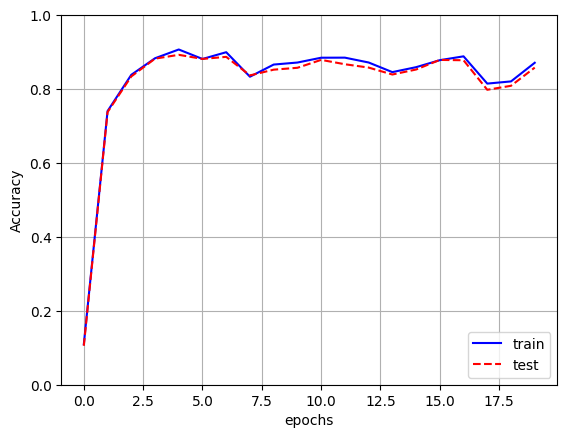

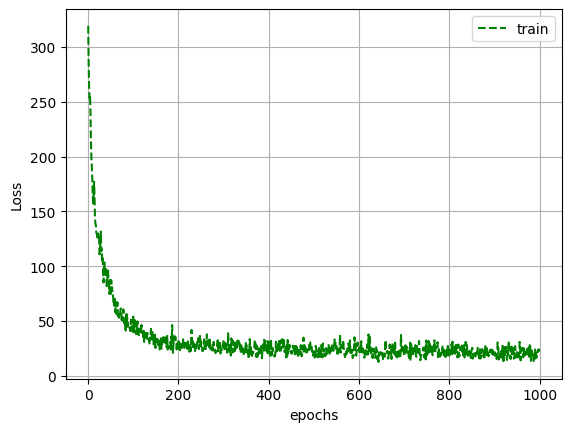

In [97]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 100, 100],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.15,
				'use_dropout' : False,
				'dropout_ratio' : 0.5, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 3,
				'lr' : 0.01,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 100,
				'epochs' : 1000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

#### 시각화

In [98]:
np.random.seed(42)

train_size = 60000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:train_size]
x_test = x_test[:10000]
y_train = y_train[:train_size]
y_test = y_test[:10000]
x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32)
x_train, x_test = x_train/.255, x_test/.255

y_train = np.eye(num_classes)[y_train]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000,)


[Model_4] Epoch: 0  Train Loss: 354.3217 Train Accuracy: 0.0934 Test Accuracy: 0.0926
[Model_4] Epoch: 50  Train Loss: 199.2098 Train Accuracy: 0.6725 Test Accuracy: 0.6759
[Model_4] Epoch: 100  Train Loss: 110.9891 Train Accuracy: 0.8309 Test Accuracy: 0.841
[Model_4] Epoch: 150  Train Loss: 75.3382 Train Accuracy: 0.87 Test Accuracy: 0.8725
[Model_4] Epoch: 200  Train Loss: 55.4315 Train Accuracy: 0.9074 Test Accuracy: 0.9089
[Model_4] Epoch: 250  Train Loss: 51.8194 Train Accuracy: 0.9217 Test Accuracy: 0.9237
[Model_4] Epoch: 300  Train Loss: 57.8746 Train Accuracy: 0.8869 Test Accuracy: 0.8908
[Model_4] Epoch: 350  Train Loss: 47.248 Train Accuracy: 0.8869 Test Accuracy: 0.8874
[Model_4] Epoch: 400  Train Loss: 40.3878 Train Accuracy: 0.8948 Test Accuracy: 0.898
[Model_4] Epoch: 450  Train Loss: 45.9451 Train Accuracy: 0.8863 Test Accuracy: 0.8888
[Model_4] Epoch: 500  Train Loss: 31.0353 Train Accuracy: 0.8515 Test Accuracy: 0.8522
[Model_4] Epoch: 550  Train Loss: 37.4674 Train 

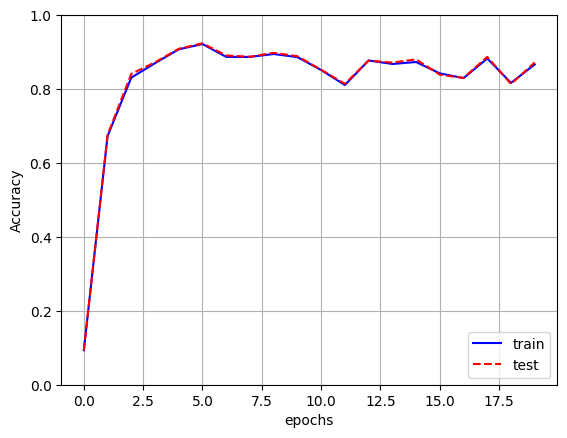

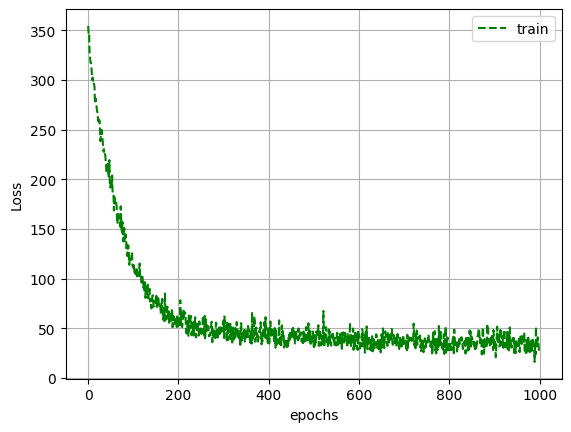

In [103]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 128, 128, 64],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 4,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 128,
				'epochs' : 1000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_5] Epoch: 0  Train Loss: 390.8548 Train Accuracy: 0.1214 Test Accuracy: 0.119
[Model_5] Epoch: 50  Train Loss: 295.9209 Train Accuracy: 0.2852 Test Accuracy: 0.282
[Model_5] Epoch: 100  Train Loss: 230.708 Train Accuracy: 0.5102 Test Accuracy: 0.5198
[Model_5] Epoch: 150  Train Loss: 178.851 Train Accuracy: 0.6721 Test Accuracy: 0.6769
[Model_5] Epoch: 200  Train Loss: 133.298 Train Accuracy: 0.8039 Test Accuracy: 0.8113
[Model_5] Epoch: 250  Train Loss: 98.2951 Train Accuracy: 0.8324 Test Accuracy: 0.8385
[Model_5] Epoch: 300  Train Loss: 67.3755 Train Accuracy: 0.8624 Test Accuracy: 0.867
[Model_5] Epoch: 350  Train Loss: 65.153 Train Accuracy: 0.8769 Test Accuracy: 0.8817
[Model_5] Epoch: 400  Train Loss: 64.7531 Train Accuracy: 0.8547 Test Accuracy: 0.8675
[Model_5] Epoch: 450  Train Loss: 67.4229 Train Accuracy: 0.871 Test Accuracy: 0.8794
[Model_5] Epoch: 500  Train Loss: 55.4647 Train Accuracy: 0.881 Test Accuracy: 0.885
[Model_5] Epoch: 550  Train Loss: 53.1251 Train Acc

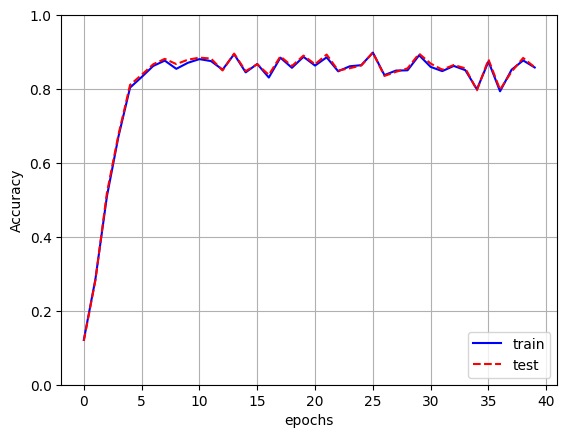

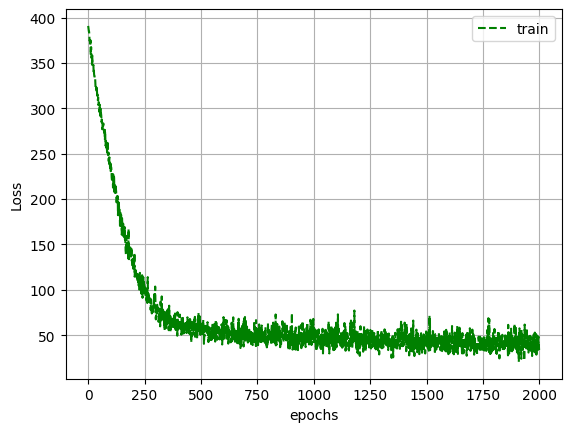

In [104]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 128, 128, 128, 64],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.13,
				'use_dropout' : True,
				'dropout_ratio' : 0.4, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 5,
				'lr' : 0.01,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 128,
				'epochs' : 2000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_6] Epoch: 0  Train Loss: 231.1976 Train Accuracy: 0.0876 Test Accuracy: 0.0836
[Model_6] Epoch: 50  Train Loss: 180.3974 Train Accuracy: 0.2098 Test Accuracy: 0.2171
[Model_6] Epoch: 100  Train Loss: 159.3004 Train Accuracy: 0.4108 Test Accuracy: 0.406
[Model_6] Epoch: 150  Train Loss: 140.7442 Train Accuracy: 0.4318 Test Accuracy: 0.4309
[Model_6] Epoch: 200  Train Loss: 121.5763 Train Accuracy: 0.4992 Test Accuracy: 0.4986
[Model_6] Epoch: 250  Train Loss: 100.8462 Train Accuracy: 0.5555 Test Accuracy: 0.5534
[Model_6] Epoch: 300  Train Loss: 93.1203 Train Accuracy: 0.5781 Test Accuracy: 0.5769
[Model_6] Epoch: 350  Train Loss: 87.5643 Train Accuracy: 0.5794 Test Accuracy: 0.5804
[Model_6] Epoch: 400  Train Loss: 73.2099 Train Accuracy: 0.6533 Test Accuracy: 0.6544
[Model_6] Epoch: 450  Train Loss: 59.8251 Train Accuracy: 0.6801 Test Accuracy: 0.6835
[Model_6] Epoch: 500  Train Loss: 67.0851 Train Accuracy: 0.6794 Test Accuracy: 0.6803
[Model_6] Epoch: 550  Train Loss: 59.2656

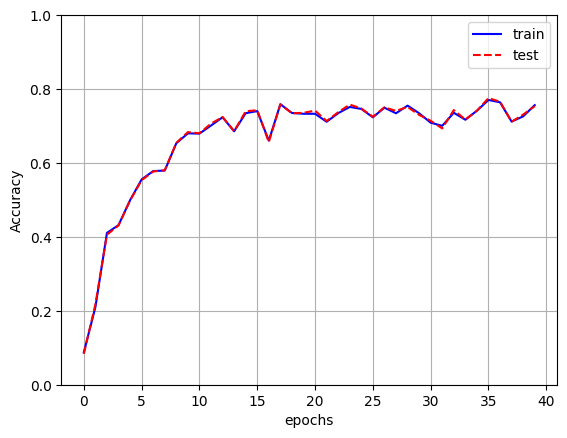

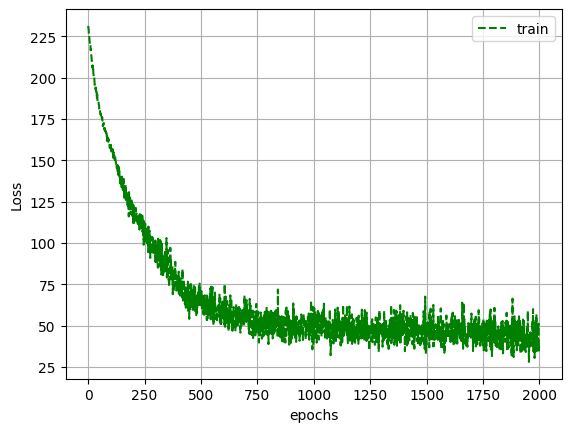

In [105]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 64, 128, 128, 64],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.13,
				'use_dropout' : True,
				'dropout_ratio' : 0.5, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 6,
				'lr' : 0.01,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 64,
				'epochs' : 2000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_7] Epoch: 0  Train Loss: 681.6834 Train Accuracy: 0.1036 Test Accuracy: 0.1012
[Model_7] Epoch: 50  Train Loss: 519.9783 Train Accuracy: 0.4192 Test Accuracy: 0.4109
[Model_7] Epoch: 100  Train Loss: 418.496 Train Accuracy: 0.5764 Test Accuracy: 0.5863
[Model_7] Epoch: 150  Train Loss: 333.2326 Train Accuracy: 0.6328 Test Accuracy: 0.6299
[Model_7] Epoch: 200  Train Loss: 260.9307 Train Accuracy: 0.7385 Test Accuracy: 0.7419
[Model_7] Epoch: 250  Train Loss: 200.4392 Train Accuracy: 0.775 Test Accuracy: 0.7763
[Model_7] Epoch: 300  Train Loss: 199.4431 Train Accuracy: 0.7706 Test Accuracy: 0.7658
[Model_7] Epoch: 350  Train Loss: 157.5386 Train Accuracy: 0.7996 Test Accuracy: 0.7995
[Model_7] Epoch: 400  Train Loss: 138.8558 Train Accuracy: 0.797 Test Accuracy: 0.7984
[Model_7] Epoch: 450  Train Loss: 132.6151 Train Accuracy: 0.818 Test Accuracy: 0.8234
[Model_7] Epoch: 500  Train Loss: 122.6292 Train Accuracy: 0.8662 Test Accuracy: 0.8715
[Model_7] Epoch: 550  Train Loss: 108.1

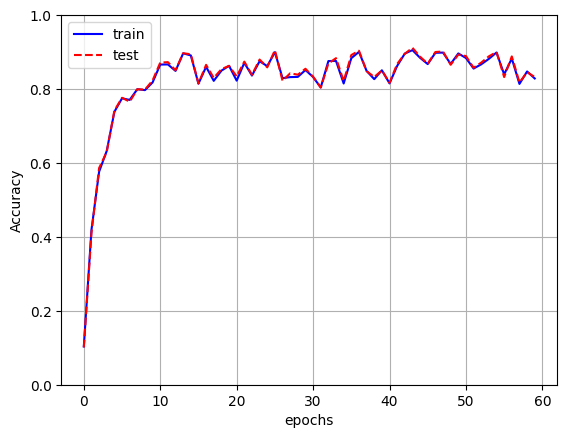

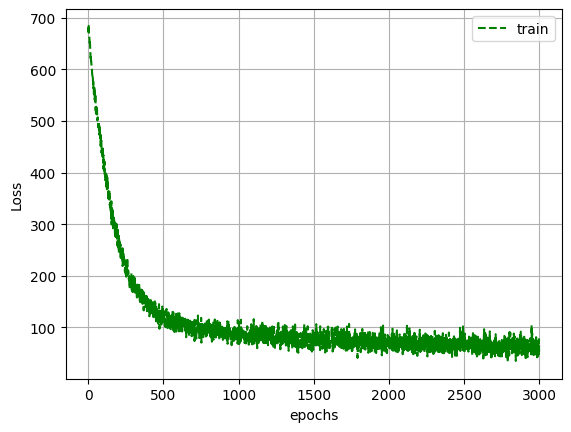

In [106]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 64, 128, 128, 64, 32],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.13,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 7,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 3000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_8] Epoch: 0  Train Loss: 690.1456 Train Accuracy: 0.0833 Test Accuracy: 0.0828
[Model_8] Epoch: 50  Train Loss: 545.501 Train Accuracy: 0.3842 Test Accuracy: 0.3942
[Model_8] Epoch: 100  Train Loss: 424.1814 Train Accuracy: 0.5756 Test Accuracy: 0.5844
[Model_8] Epoch: 150  Train Loss: 301.4904 Train Accuracy: 0.7533 Test Accuracy: 0.7547
[Model_8] Epoch: 200  Train Loss: 239.4849 Train Accuracy: 0.8175 Test Accuracy: 0.8159
[Model_8] Epoch: 250  Train Loss: 191.687 Train Accuracy: 0.896 Test Accuracy: 0.8975
[Model_8] Epoch: 300  Train Loss: 155.6888 Train Accuracy: 0.8442 Test Accuracy: 0.8439
[Model_8] Epoch: 350  Train Loss: 135.0701 Train Accuracy: 0.8975 Test Accuracy: 0.9044
[Model_8] Epoch: 400  Train Loss: 124.3018 Train Accuracy: 0.8756 Test Accuracy: 0.8821
[Model_8] Epoch: 450  Train Loss: 122.3996 Train Accuracy: 0.8685 Test Accuracy: 0.8693
[Model_8] Epoch: 500  Train Loss: 112.1523 Train Accuracy: 0.8784 Test Accuracy: 0.8859
[Model_8] Epoch: 550  Train Loss: 110.

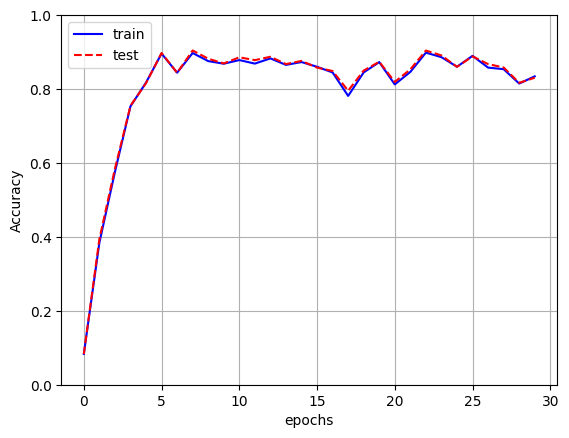

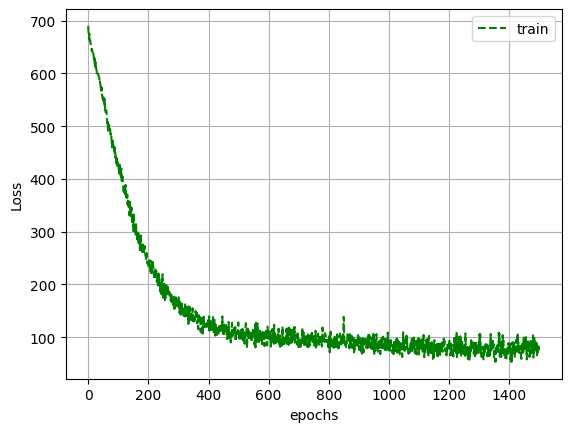

In [108]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 64, 128, 128, 64, 32],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.13,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 8,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 1500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_9] Epoch: 0  Train Loss: 1323.3886 Train Accuracy: 0.072 Test Accuracy: 0.0775
[Model_9] Epoch: 50  Train Loss: 985.4748 Train Accuracy: 0.385 Test Accuracy: 0.3966
[Model_9] Epoch: 100  Train Loss: 713.0465 Train Accuracy: 0.5728 Test Accuracy: 0.5699
[Model_9] Epoch: 150  Train Loss: 488.3647 Train Accuracy: 0.8247 Test Accuracy: 0.8248
[Model_9] Epoch: 200  Train Loss: 376.8321 Train Accuracy: 0.8982 Test Accuracy: 0.8976
[Model_9] Epoch: 250  Train Loss: 241.7576 Train Accuracy: 0.9071 Test Accuracy: 0.9054
[Model_9] Epoch: 300  Train Loss: 210.5306 Train Accuracy: 0.8725 Test Accuracy: 0.8748
[Model_9] Epoch: 350  Train Loss: 189.1299 Train Accuracy: 0.8906 Test Accuracy: 0.8907
[Model_9] Epoch: 400  Train Loss: 169.1261 Train Accuracy: 0.8576 Test Accuracy: 0.8591
[Model_9] Epoch: 450  Train Loss: 168.2056 Train Accuracy: 0.8242 Test Accuracy: 0.8245


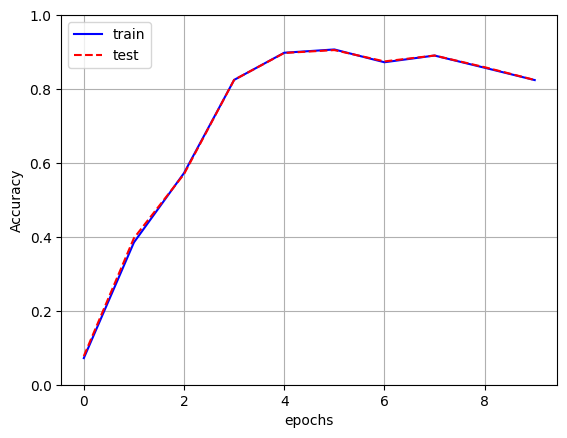

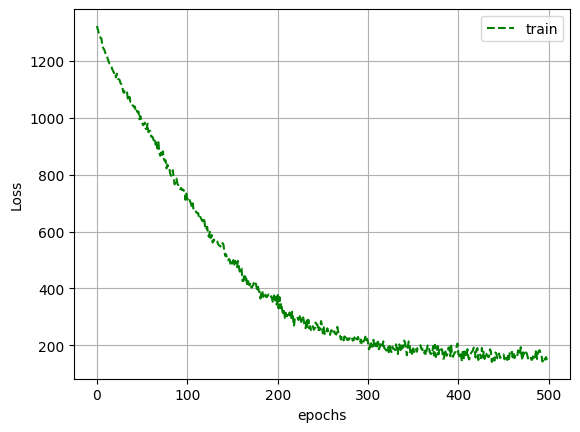

In [110]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 64, 128, 128, 64, 64, 32],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.15,
				'use_dropout' : True,
				'dropout_ratio' : 0.2, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 9,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_10] Epoch: 0  Train Loss: 711.4292 Train Accuracy: 0.1027 Test Accuracy: 0.1015
[Model_10] Epoch: 50  Train Loss: 552.2791 Train Accuracy: 0.2132 Test Accuracy: 0.2063
[Model_10] Epoch: 100  Train Loss: 395.2544 Train Accuracy: 0.5107 Test Accuracy: 0.5038
[Model_10] Epoch: 150  Train Loss: 290.7276 Train Accuracy: 0.6841 Test Accuracy: 0.6821
[Model_10] Epoch: 200  Train Loss: 212.6188 Train Accuracy: 0.793 Test Accuracy: 0.7937
[Model_10] Epoch: 250  Train Loss: 165.8534 Train Accuracy: 0.8405 Test Accuracy: 0.8401
[Model_10] Epoch: 300  Train Loss: 129.1638 Train Accuracy: 0.8609 Test Accuracy: 0.8726
[Model_10] Epoch: 350  Train Loss: 129.7781 Train Accuracy: 0.7952 Test Accuracy: 0.7888
[Model_10] Epoch: 400  Train Loss: 98.2231 Train Accuracy: 0.8016 Test Accuracy: 0.7993
[Model_10] Epoch: 450  Train Loss: 114.361 Train Accuracy: 0.856 Test Accuracy: 0.8584
[Model_10] Epoch: 500  Train Loss: 102.1909 Train Accuracy: 0.8652 Test Accuracy: 0.8602
[Model_10] Epoch: 550  Train

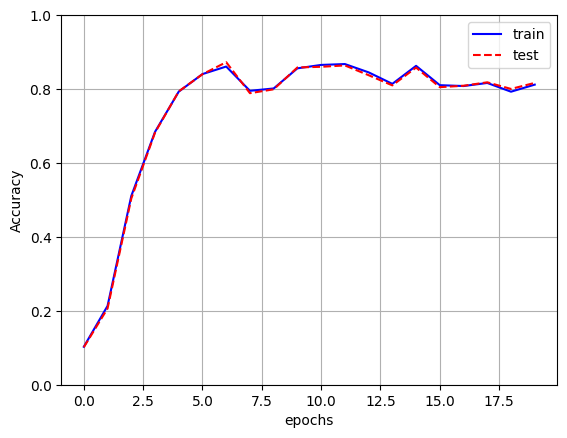

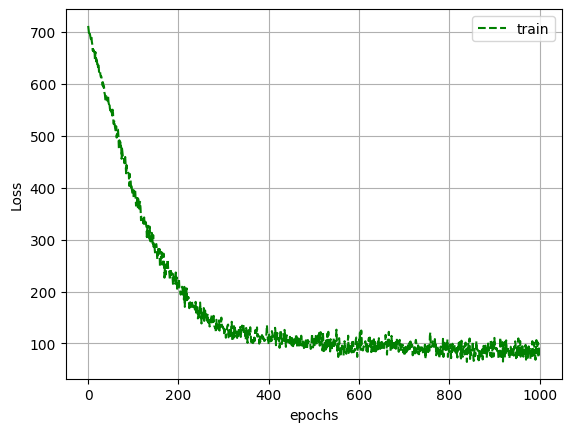

In [112]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 64, 128, 128, 64, 64, 32],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.15,
				'use_dropout' : True,
				'dropout_ratio' : 0.2, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 10,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 1000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_11] Epoch: 0  Train Loss: 729.8079 Train Accuracy: 0.0879 Test Accuracy: 0.0861
[Model_11] Epoch: 50  Train Loss: 376.5733 Train Accuracy: 0.5924 Test Accuracy: 0.5949
[Model_11] Epoch: 100  Train Loss: 189.6491 Train Accuracy: 0.8292 Test Accuracy: 0.8342
[Model_11] Epoch: 150  Train Loss: 114.3817 Train Accuracy: 0.905 Test Accuracy: 0.9071
[Model_11] Epoch: 200  Train Loss: 96.7596 Train Accuracy: 0.8383 Test Accuracy: 0.8385
[Model_11] Epoch: 250  Train Loss: 86.1429 Train Accuracy: 0.8683 Test Accuracy: 0.8654
[Model_11] Epoch: 300  Train Loss: 87.1194 Train Accuracy: 0.8778 Test Accuracy: 0.8814
[Model_11] Epoch: 350  Train Loss: 66.4652 Train Accuracy: 0.905 Test Accuracy: 0.9114
[Model_11] Epoch: 400  Train Loss: 90.4584 Train Accuracy: 0.8489 Test Accuracy: 0.8463
[Model_11] Epoch: 450  Train Loss: 80.1566 Train Accuracy: 0.7761 Test Accuracy: 0.7832
[Model_11] Epoch: 500  Train Loss: 77.2528 Train Accuracy: 0.8676 Test Accuracy: 0.8671
[Model_11] Epoch: 550  Train Loss

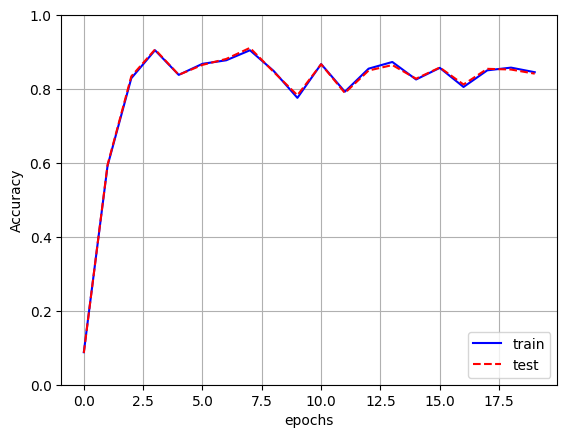

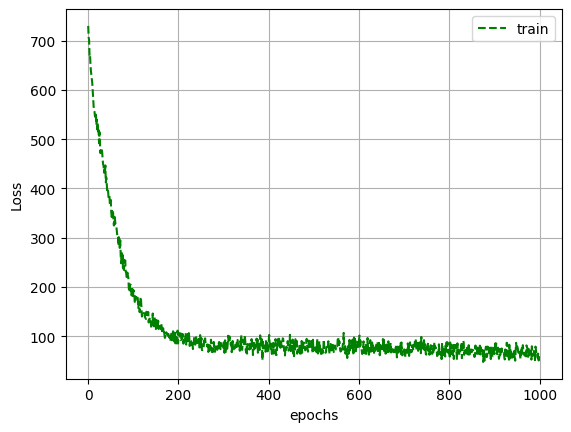

In [113]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 128, 128, 64, 32],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.2, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 11,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 1000,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_12] Epoch: 0  Train Loss: 1301.265 Train Accuracy: 0.1437 Test Accuracy: 0.1418
[Model_12] Epoch: 50  Train Loss: 461.0629 Train Accuracy: 0.8216 Test Accuracy: 0.8245
[Model_12] Epoch: 100  Train Loss: 199.7886 Train Accuracy: 0.9125 Test Accuracy: 0.914
[Model_12] Epoch: 150  Train Loss: 146.1538 Train Accuracy: 0.9214 Test Accuracy: 0.922
[Model_12] Epoch: 200  Train Loss: 106.3269 Train Accuracy: 0.8981 Test Accuracy: 0.898
[Model_12] Epoch: 250  Train Loss: 110.9072 Train Accuracy: 0.8142 Test Accuracy: 0.8137
[Model_12] Epoch: 300  Train Loss: 104.2646 Train Accuracy: 0.8726 Test Accuracy: 0.8796
[Model_12] Epoch: 350  Train Loss: 97.3997 Train Accuracy: 0.8764 Test Accuracy: 0.8783
[Model_12] Epoch: 400  Train Loss: 102.7713 Train Accuracy: 0.8676 Test Accuracy: 0.869
[Model_12] Epoch: 450  Train Loss: 88.6275 Train Accuracy: 0.863 Test Accuracy: 0.8584


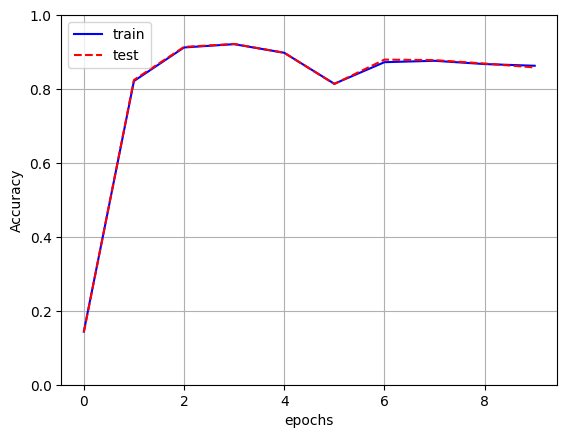

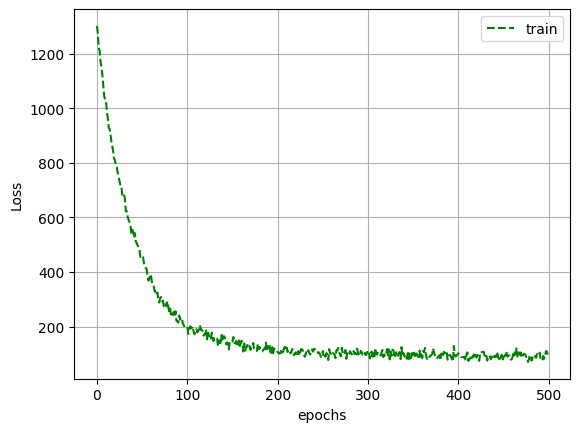

In [118]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 128, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 12,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_13] Epoch: 0  Train Loss: 1281.6934 Train Accuracy: 0.1491 Test Accuracy: 0.1476
[Model_13] Epoch: 50  Train Loss: 351.3881 Train Accuracy: 0.8503 Test Accuracy: 0.8563
[Model_13] Epoch: 100  Train Loss: 152.7722 Train Accuracy: 0.9258 Test Accuracy: 0.9275
[Model_13] Epoch: 150  Train Loss: 102.9469 Train Accuracy: 0.907 Test Accuracy: 0.903
[Model_13] Epoch: 200  Train Loss: 115.6806 Train Accuracy: 0.8274 Test Accuracy: 0.8338
[Model_13] Epoch: 250  Train Loss: 94.9104 Train Accuracy: 0.8634 Test Accuracy: 0.8631
[Model_13] Epoch: 300  Train Loss: 100.5692 Train Accuracy: 0.8866 Test Accuracy: 0.8917
[Model_13] Epoch: 350  Train Loss: 88.8952 Train Accuracy: 0.8646 Test Accuracy: 0.8661
[Model_13] Epoch: 400  Train Loss: 76.5571 Train Accuracy: 0.8778 Test Accuracy: 0.873
[Model_13] Epoch: 450  Train Loss: 92.7131 Train Accuracy: 0.8744 Test Accuracy: 0.8737


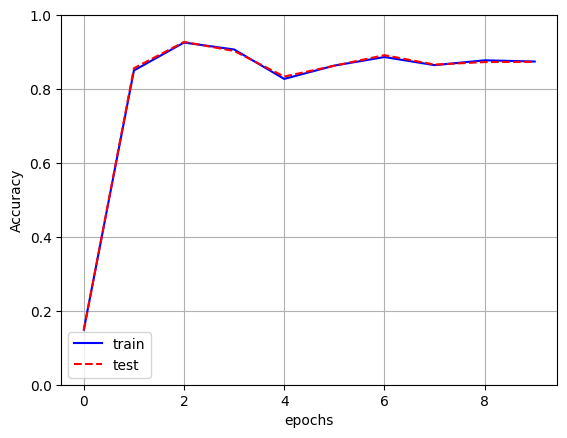

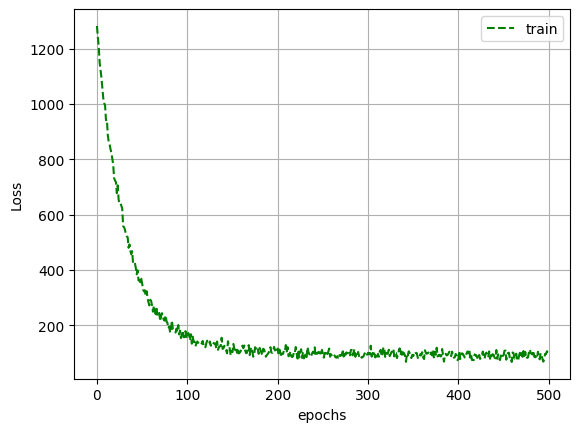

In [120]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 512, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 13,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_14] Epoch: 0  Train Loss: 1287.5694 Train Accuracy: 0.1528 Test Accuracy: 0.1534
[Model_14] Epoch: 50  Train Loss: 347.6047 Train Accuracy: 0.7971 Test Accuracy: 0.8012
[Model_14] Epoch: 100  Train Loss: 194.2552 Train Accuracy: 0.912 Test Accuracy: 0.913
[Model_14] Epoch: 150  Train Loss: 111.8776 Train Accuracy: 0.9302 Test Accuracy: 0.9287
[Model_14] Epoch: 200  Train Loss: 109.1734 Train Accuracy: 0.9184 Test Accuracy: 0.9161
[Model_14] Epoch: 250  Train Loss: 89.1939 Train Accuracy: 0.9115 Test Accuracy: 0.9132
[Model_14] Epoch: 300  Train Loss: 93.8529 Train Accuracy: 0.9036 Test Accuracy: 0.9035
[Model_14] Epoch: 350  Train Loss: 89.2196 Train Accuracy: 0.8454 Test Accuracy: 0.8487
[Model_14] Epoch: 400  Train Loss: 83.2145 Train Accuracy: 0.8696 Test Accuracy: 0.8688
[Model_14] Epoch: 450  Train Loss: 96.3087 Train Accuracy: 0.8555 Test Accuracy: 0.8535


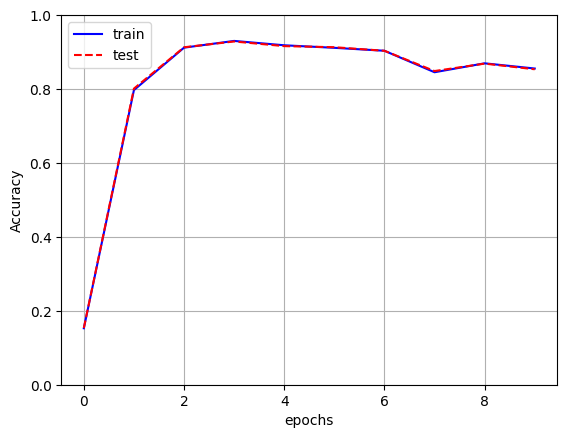

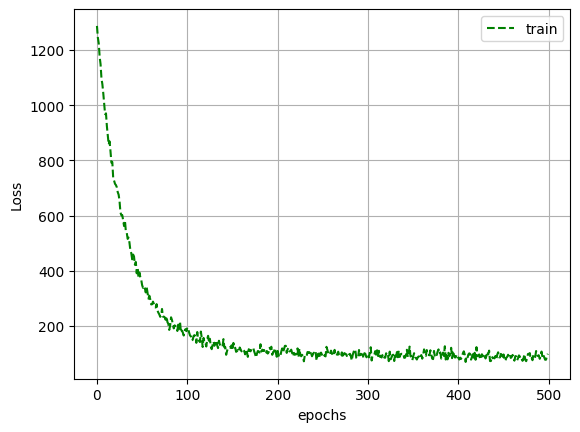

In [121]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 256, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 14,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_15] Epoch: 0  Train Loss: 1297.4013 Train Accuracy: 0.0944 Test Accuracy: 0.0941
[Model_15] Epoch: 50  Train Loss: 650.5889 Train Accuracy: 0.7376 Test Accuracy: 0.7372
[Model_15] Epoch: 100  Train Loss: 261.3583 Train Accuracy: 0.8941 Test Accuracy: 0.8952
[Model_15] Epoch: 150  Train Loss: 169.3725 Train Accuracy: 0.916 Test Accuracy: 0.9126
[Model_15] Epoch: 200  Train Loss: 108.0153 Train Accuracy: 0.9116 Test Accuracy: 0.9082
[Model_15] Epoch: 250  Train Loss: 89.5704 Train Accuracy: 0.9112 Test Accuracy: 0.9079
[Model_15] Epoch: 300  Train Loss: 94.8368 Train Accuracy: 0.8334 Test Accuracy: 0.8377
[Model_15] Epoch: 350  Train Loss: 95.5516 Train Accuracy: 0.9024 Test Accuracy: 0.9005
[Model_15] Epoch: 400  Train Loss: 102.6373 Train Accuracy: 0.8784 Test Accuracy: 0.8886
[Model_15] Epoch: 450  Train Loss: 71.6295 Train Accuracy: 0.8894 Test Accuracy: 0.8894


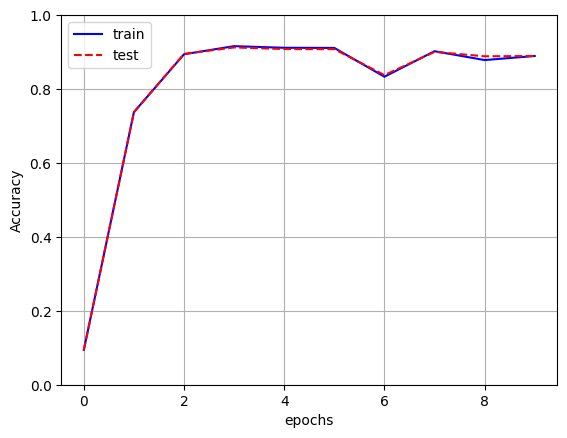

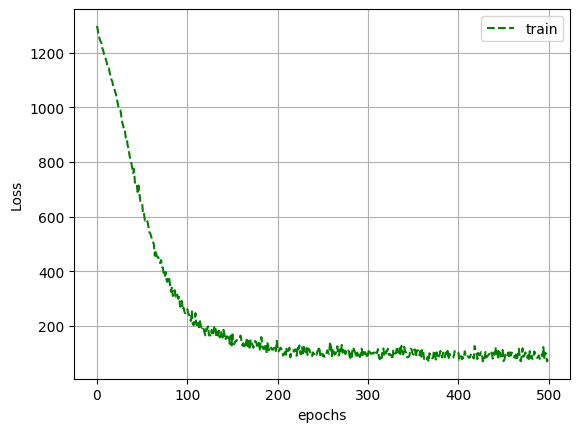

In [122]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 256, 256, 128, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 15,
				'lr' : 0.001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_16] Epoch: 0  Train Loss: 1260.5332 Train Accuracy: 0.1257 Test Accuracy: 0.1276
[Model_16] Epoch: 50  Train Loss: 455.9551 Train Accuracy: 0.8087 Test Accuracy: 0.8133
[Model_16] Epoch: 100  Train Loss: 210.9788 Train Accuracy: 0.8952 Test Accuracy: 0.9
[Model_16] Epoch: 150  Train Loss: 145.6975 Train Accuracy: 0.92 Test Accuracy: 0.9227
[Model_16] Epoch: 200  Train Loss: 100.0253 Train Accuracy: 0.8912 Test Accuracy: 0.8923
[Model_16] Epoch: 250  Train Loss: 97.4768 Train Accuracy: 0.904 Test Accuracy: 0.9027


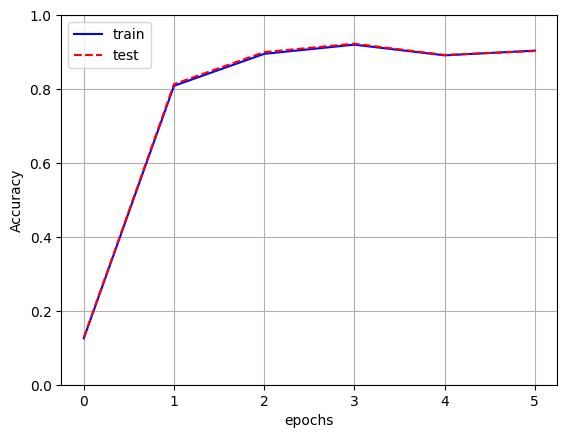

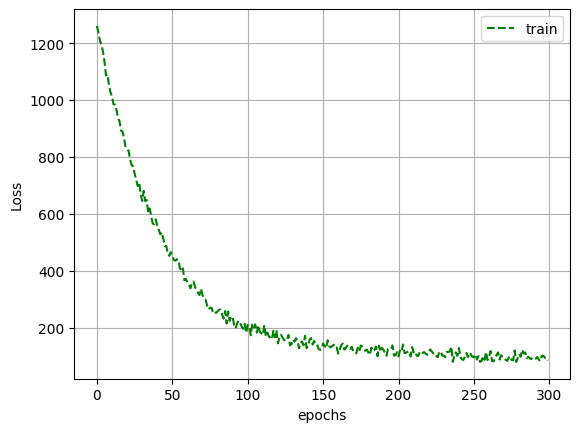

In [125]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 256, 256, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 16,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 512,
				'epochs' : 300,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_17] Epoch: 0  Train Loss: 681.8541 Train Accuracy: 0.0984 Test Accuracy: 0.1008
[Model_17] Epoch: 50  Train Loss: 267.1822 Train Accuracy: 0.804 Test Accuracy: 0.8083
[Model_17] Epoch: 100  Train Loss: 126.4602 Train Accuracy: 0.895 Test Accuracy: 0.898
[Model_17] Epoch: 150  Train Loss: 84.0746 Train Accuracy: 0.9183 Test Accuracy: 0.9191
[Model_17] Epoch: 200  Train Loss: 60.3873 Train Accuracy: 0.9198 Test Accuracy: 0.9196
[Model_17] Epoch: 250  Train Loss: 47.5667 Train Accuracy: 0.9235 Test Accuracy: 0.9232


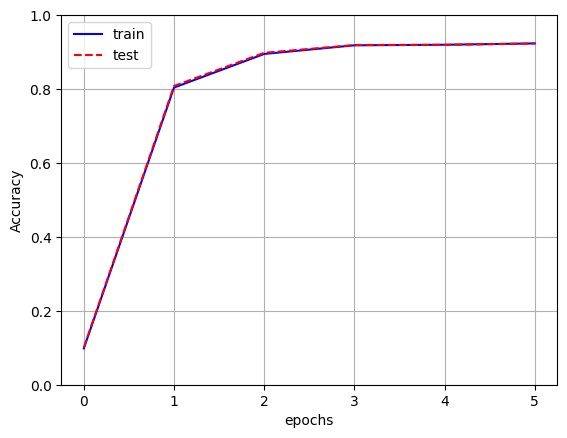

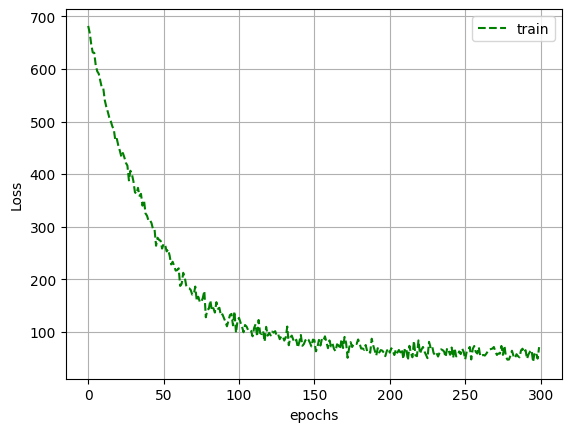

In [126]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 256, 256, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 17,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 300,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_18] Epoch: 0  Train Loss: 693.1421 Train Accuracy: 0.139 Test Accuracy: 0.1399
[Model_18] Epoch: 50  Train Loss: 213.5928 Train Accuracy: 0.7918 Test Accuracy: 0.7917
[Model_18] Epoch: 100  Train Loss: 94.8827 Train Accuracy: 0.9031 Test Accuracy: 0.9049
[Model_18] Epoch: 150  Train Loss: 69.4863 Train Accuracy: 0.9038 Test Accuracy: 0.9082
[Model_18] Epoch: 200  Train Loss: 45.9158 Train Accuracy: 0.8988 Test Accuracy: 0.899
[Model_18] Epoch: 250  Train Loss: 56.4746 Train Accuracy: 0.9104 Test Accuracy: 0.9128
[Model_18] Epoch: 300  Train Loss: 58.833 Train Accuracy: 0.8588 Test Accuracy: 0.8609
[Model_18] Epoch: 350  Train Loss: 53.8924 Train Accuracy: 0.852 Test Accuracy: 0.8562
[Model_18] Epoch: 400  Train Loss: 56.0231 Train Accuracy: 0.846 Test Accuracy: 0.8432
[Model_18] Epoch: 450  Train Loss: 51.8731 Train Accuracy: 0.8548 Test Accuracy: 0.851


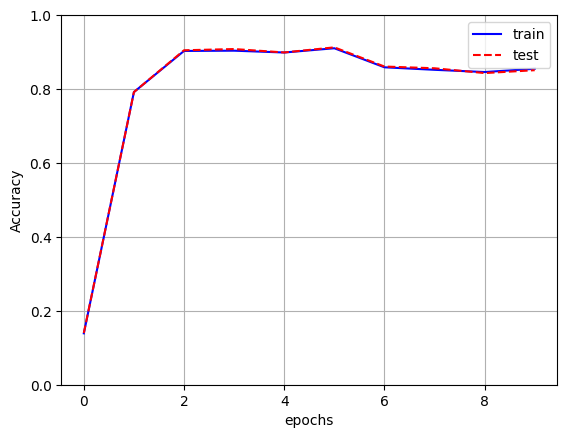

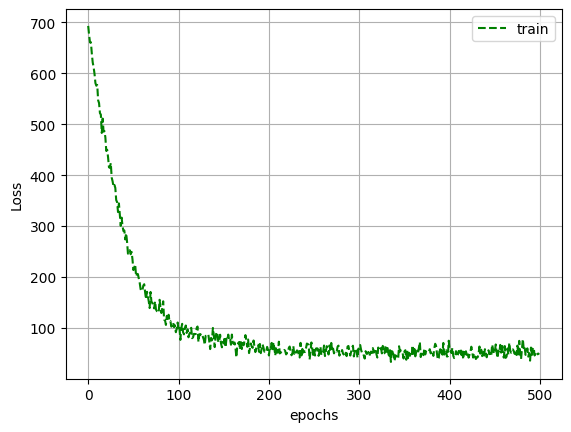

In [128]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 256, 256, 256],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 18,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_19] Epoch: 0  Train Loss: 388.6063 Train Accuracy: 0.1499 Test Accuracy: 0.1491
[Model_19] Epoch: 50  Train Loss: 163.8202 Train Accuracy: 0.6597 Test Accuracy: 0.6643
[Model_19] Epoch: 100  Train Loss: 85.8336 Train Accuracy: 0.8435 Test Accuracy: 0.8446
[Model_19] Epoch: 150  Train Loss: 50.6916 Train Accuracy: 0.9078 Test Accuracy: 0.9107
[Model_19] Epoch: 200  Train Loss: 45.1362 Train Accuracy: 0.889 Test Accuracy: 0.8862
[Model_19] Epoch: 250  Train Loss: 48.0321 Train Accuracy: 0.8944 Test Accuracy: 0.8985


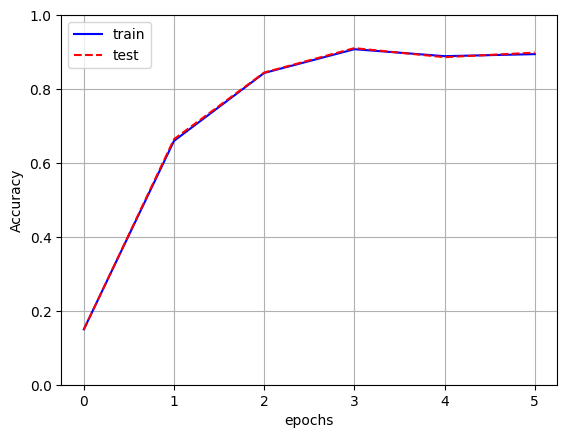

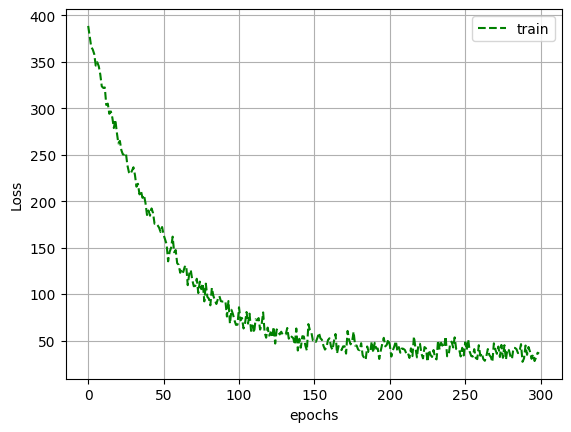

In [129]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 256, 256, 128],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 19,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 128,
				'epochs' : 300,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_21] Epoch: 0  Train Loss: 647.6883 Train Accuracy: 0.1192 Test Accuracy: 0.1142
[Model_21] Epoch: 50  Train Loss: 175.7606 Train Accuracy: 0.8163 Test Accuracy: 0.8237
[Model_21] Epoch: 100  Train Loss: 92.6991 Train Accuracy: 0.9085 Test Accuracy: 0.9123
[Model_21] Epoch: 150  Train Loss: 74.8844 Train Accuracy: 0.9228 Test Accuracy: 0.9223
[Model_21] Epoch: 200  Train Loss: 57.5083 Train Accuracy: 0.8846 Test Accuracy: 0.887
[Model_21] Epoch: 250  Train Loss: 73.1743 Train Accuracy: 0.9131 Test Accuracy: 0.9143
[Model_21] Epoch: 300  Train Loss: 43.6044 Train Accuracy: 0.8879 Test Accuracy: 0.8937
[Model_21] Epoch: 350  Train Loss: 43.9867 Train Accuracy: 0.8735 Test Accuracy: 0.8699
[Model_21] Epoch: 400  Train Loss: 44.4457 Train Accuracy: 0.9007 Test Accuracy: 0.9006
[Model_21] Epoch: 450  Train Loss: 59.2037 Train Accuracy: 0.9151 Test Accuracy: 0.9126


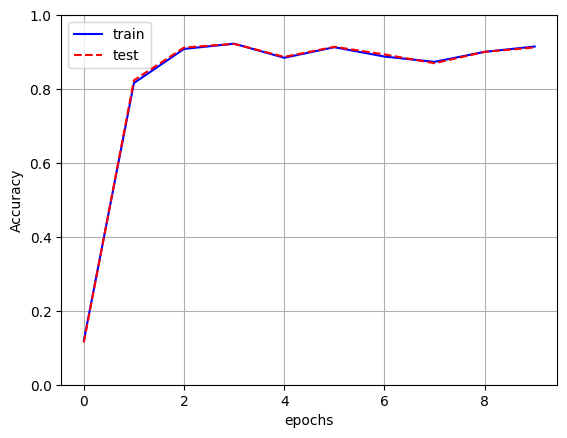

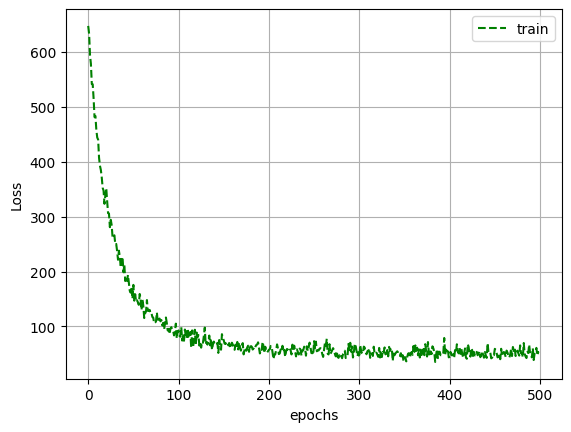

In [142]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 256],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 21,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 500,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

[Model_22] Epoch: 0  Train Loss: 703.9966 Train Accuracy: 0.1257 Test Accuracy: 0.1247
[Model_22] Epoch: 50  Train Loss: 215.3372 Train Accuracy: 0.7924 Test Accuracy: 0.7982
[Model_22] Epoch: 100  Train Loss: 98.0187 Train Accuracy: 0.8947 Test Accuracy: 0.9023
[Model_22] Epoch: 150  Train Loss: 58.9755 Train Accuracy: 0.9289 Test Accuracy: 0.9325
[Model_22] Epoch: 200  Train Loss: 52.8404 Train Accuracy: 0.8692 Test Accuracy: 0.8696
[Model_22] Epoch: 250  Train Loss: 46.6395 Train Accuracy: 0.9094 Test Accuracy: 0.911


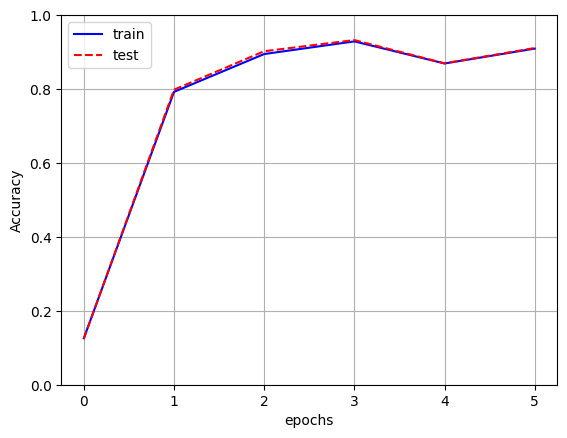

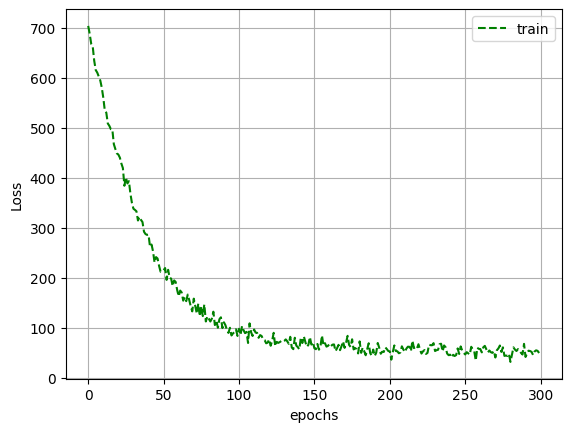

In [155]:
trn_params = {
				'input_size' : 784, 
				'hidden_size_list' : [256, 512, 256, 256],
				'output_size' : 10, 
				'activation' : 'relu', 
				'decay_lambda' : 0.1,
				'use_dropout' : True,
				'dropout_ratio' : 0.3, 
				'use_batchnorm' : True
				}

epoch_params = {
				'model' : MyModel(**trn_params),
				'test_case' : 22,
				'lr' : 0.0001,
				'optimizer' : Adam(lr=lr),
				'batch_size' : 256,
				'epochs' : 300,
				'train_size' : x_train.shape[0],
				'iter_per_epoch' : max(train_size/batch_size, 1)
				}


train_epoch(**epoch_params)

In [158]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [159]:
x.T.shape

(28, 28, 1, 10)

### 3가지 모델 비교
- 위의 3가지 모델은 전체적으로 학습 데이터 수를 일부로 제한했기 때문에 학습이 잘 안 될 가능성이 높음  
  - 따라서 여러 학습 기술들을 적용함
